# INFO 2950 Project Phase II

By Colin Hoffer, Michael Wang, John Lo, and Patricio Fraga-Errecart

---
## Research Questions

The effects of various factors (education, taxes, income) on average housing prices.
What factors are the best for predicting housing prices within a particular city?

---
## Data Collection and Cleaning

The first dataset we decided to use was the Zillow Home Value Index (found [here](https://www.zillow.com/research/data/)) which "reflects the typical value for homes in the 35th to 65th percentile range for a given region." We thought this would be a good estimate of housing prices in various cities. This dataset is organized by metropolitan statistical area (MSA), which usually encompasses multiple counties surrounding a large city. We thought this would give us more accurate and varied data as opposed to using data from the cities' limits themselves. 



The cities we decided to focus on are: New York, NY; Boston, MA; Washington, DC; San Francisco, CA; Los Angeles, CA; Miami, FL; Louisville, KY; Cincinatti, OH; Houston, TX; Denver, CO; Chicago, IL; and Seattle, WA. We thought these choices were a good variety of climate, geography, and demographics.

As for the factors that we want to compare with housing prices, we found a [useful table builder](https://data.census.gov/mdat/#/) on the US Census Website that allowed us to gather data on education completion, household income, gross rent as a percentage of income (used to estimate home affordability), and property taxes for each of the intended MSAs. Unfortunately, these tables were slightly difficult to organize due to the fact that the date could only be organized by counties or districts, not MSAs. To get around this, we downloaded the csv files and consolidated them below so that we had 1 datapoint for each category in each MSA.

We also wanted to see if weather or climate had an effect on housing prices, so we utilized the [NOAA National Weather Service Website](https://w2.weather.gov/climate/) to calculate the Mean High Temperature, Mean Low Temperature, and Mean Annual Temperature in 2018 for each city. **We manually inputted this data into our final dataset. (Temporary? Might change)** 

In addition to these factores, we wanted to analyze the effect of crime on housing prices. We found datasets on the [FBI website](https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/topic-pages/tables/table-6) organized by MSA and year. We chose to record Violent Crime per 100k, Robbery per 100k, Property Crime per 100k, and Burglary per 100k for our our project. **Not all of our cities had data for 2018; in these cases we used data from 2017.** 
**We manually inputted this data into our final dataset. (Temporary? Might change)** 

We chose to focus on the year 2018, since it was the most recent year that was shared by all of our datasets.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
msazhvi = pd.read_csv("MSAZHVI.csv")
msazhvi.head()
msazhvi["2018 ZHVI"] = msazhvi["2018-01-31"] + msazhvi["2018-02-28"] + msazhvi["2018-03-31"] + msazhvi["2018-04-30"] + msazhvi["2018-05-31"] + msazhvi["2018-06-30"] + msazhvi["2018-07-31"] + msazhvi["2018-08-31"] + msazhvi["2018-09-30"] + msazhvi["2018-10-31"] + msazhvi["2018-11-30"] + msazhvi["2018-12-31"]
msazhvi["2018 ZHVI"]= msazhvi["2018 ZHVI"]/12
msazhvi = msazhvi[["RegionName", "2018 ZHVI"]]
msazhvi = msazhvi[msazhvi["RegionName"].isin(["New York, NY", "Chicago, IL", "Houston, TX", "Boston, MA", "Louisville-Jefferson County, KY", "Cincinnati, OH", "Washington, DC", "Denver, CO", "San Francisco, CA", "Los Angeles-Long Beach-Anaheim, CA", "Miami-Fort Lauderdale, FL", "Seattle, WA", ])]
msazhvi["Mean HS/Equivalent Educated"] = np.nan
msazhvi["Mean Bachelor's Degree Holding"] = np.nan
msazhvi["Mean Postgraduate Educated"] = np.nan
msazhvi["Mean Income"] = np.nan
msazhvi["Mean Property Tax"] = np.nan
msazhvi["Mean Rent as a Percentage of Income"] = np.nan

In [19]:
def MSA_data_frame_builder(household, education):
    ed = pd.read_csv(education)
    db = pd.read_csv(household)
    hs_or_equivalent = []
    bachelors = []
    postgrad = []
    for i in range(len(ed["Selected Geographies"])):
        percent = (ed["Regular high school diploma"][i] + ed["GED or alternative credential"][i])/ed["Total"][i]
        hs_or_equivalent.append(percent)
        percent = ed["Bachelor's degree"][i]/ ed["Total"][i]
        bachelors.append(percent)
        percent = (ed["Master's degree"][i] + ed["Professional degree beyond a bachelor's degree"][i] + ed["Doctorate degree"][i])/ ed["Total"][i]
        postgrad.append(percent)
    db["HS/Equivalent Education Percentage"] = hs_or_equivalent
    db["Bachelor's Percentage"] = bachelors
    db["Postgraduate Percentage"] = postgrad
    db.insert(loc=2, column="Total Population", value=ed["Total"])
    return db


SF = MSA_data_frame_builder("Michael's Data/SF.csv", "Michael's Data/SFEducation.csv")
LA = MSA_data_frame_builder("Michael's Data/LA.csv", "Michael's Data/LAEducation.csv")
DE = MSA_data_frame_builder("Michael's Data/Denver.csv", "Michael's Data/DenverEducation.csv")

NY = MSA_data_frame_builder("John's Data/NYC/NYC.csv", "John's Data/NYC/NYCEducation.csv")
BT = MSA_data_frame_builder("John's Data/Boston/Boston.csv", "John's Data/Boston/BostonEducation.csv")
CC = MSA_data_frame_builder("John's Data/Cincinnati/Cincinnati.csv", "John's Data/Cincinnati/CincinnatiEducation.csv")

DC = MSA_data_frame_builder("Patricio's Data/DC/DCHouses.csv", "Patricio's Data/DC/DCEducation.csv")
LV = MSA_data_frame_builder("Patricio's Data/Louisville/LouisvilleHouses.csv", "Patricio's Data/Louisville/LouisvilleEducation.csv")
ST = MSA_data_frame_builder("Patricio's Data/Seattle/SeattleHouses.csv", "Patricio's Data/Seattle/SeattleEducation.csv")

CH = MSA_data_frame_builder("Colin's Data/ChicagoData/Chicago.csv", "Colin's Data/ChicagoData/ChicagoEducation.csv")
HO = MSA_data_frame_builder("Colin's Data/HoustonData/Houston.csv", "Colin's Data/HoustonData/HoustonEducation.csv")
MI = MSA_data_frame_builder("Colin's Data/Miami-Ft.Lauderdale/Miami.csv", "Colin's Data/Miami-Ft.Lauderdale/MiamiEducation.csv")


In [22]:
def weightedMeans(location, MSAdata):
    hs = 0
    bach = 0
    post = 0
    inc = 0
    tax = 0
    grpip = 0
    
    totalHouses = MSAdata["Households"].sum()
    totalPop = MSAdata["Total Population"].sum()
    
    for i in range(len(MSAdata.index)-1):
        hs += MSAdata["HS/Equivalent Education Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        bach += MSAdata["Bachelor's Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        post += MSAdata["Postgraduate Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        inc += MSAdata["Household income (past 12 months, use ADJINC to adjust HINCP to constant dollars)"][i]*MSAdata["Households"][i]/totalHouses
        tax += MSAdata["Property taxes (yearly real estate taxes)"][i]*MSAdata["Households"][i]/totalHouses
        grpip += MSAdata["Gross rent as a percentage of household income past 12 months"][i]*MSAdata["Households"][i]/totalHouses
    
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean HS/Equivalent Educated"] = hs
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Bachelor's Degree Holding"] = bach
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Postgraduate Educated"] = post
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Income"] = inc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Property Tax"] = tax
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Rent as a Percentage of Income"] = grpip

weightedMeans("San Francisco, CA", SF)
weightedMeans("Los Angeles-Long Beach-Anaheim, CA", LA)
weightedMeans("Denver, CO", DE)

weightedMeans("New York, NY", NY)
weightedMeans("Boston, MA", BT)
weightedMeans("Cincinnati, OH", CC)

weightedMeans("Washington, DC", DC)
weightedMeans("Louisville-Jefferson County, KY", LV)
weightedMeans("Seattle, WA", ST)

weightedMeans("Chicago, IL", CH)
weightedMeans("Houston, TX", HO)
weightedMeans("Miami-Fort Lauderdale, FL", MI)


msazhvi

,RegionName,2018 ZHVI,Mean HS/Equivalent Educated,Mean Bachelor's Degree Holding,Mean Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income
1,"New York, NY",4.702898e+05,0.191949,0.180329,0.123016,97641.232946,4064.339243,16.904336
2,"Los Angeles-Long Beach-Anaheim, CA",6.584842e+05,0.161437,0.163677,0.082337,89949.963421,2458.409629,19.269835
3,"Chicago, IL",2.363690e+05,0.192492,0.168804,0.104656,82888.935938,3580.639054,11.365745
6,"Houston, TX",2.076934e+05,0.176815,0.138221,0.076109,74356.187856,2460.132827,12.184813
7,"Washington, DC",4.165819e+05,0.139137,0.193117,0.180565,120560.818279,2940.142413,12.535437
8,"Miami-Fort Lauderdale, FL",2.871426e+05,0.202726,0.159232,0.098067,59572.771936,1796.829220,14.138335
10,"Boston, MA",4.790218e+05,0.163174,0.194791,0.159662,103301.029820,3285.172256,13.718253
11,"San Francisco, CA",1.103116e+06,0.127812,0.229953,0.152991,131980.118375,3790.872647,14.226921
15,"Seattle, WA",5.061742e+05,0.147645,0.197843,0.117782,102034.485722,2810.999842,13.163311
21,"Denver, CO",4.225489e+05,0.156835,0.199444,0.114301,110434.632370,1688.723471,11.666200


---
## Data Description

The rows represent 12 Metropolitan Statistical Areas (MSAs) throughout different geographical regions of the US. The columns are different attributes of this MSA, including average home value, highest education attained, income, property taxes, and rent as a percent of income. This dataset was created to interpret our data easier. We had many different observations and calculations that culminated into our final data frame. All data was free and we required no funding, but it came from places like the census and .gov sources. The processes where we ignored data came from looking at the country geographically and choosing cities from diversified areas. We recorded data that we felt could have an impact on housing prices, and other metrics that may be reflective of wealthy areas. We preprocessed some data in excel to make it easier to be called on later for each city. The census did not allow multiple variables at once, so every city had 5 different downloads alone to create two .csv files for the city. People were involved and they were aware, since they had filled out the census. Our data sources are linked in the data collection section


---
## Data Limitations

- The census data does match up with the Zillow data exactly. This is because the Zillow data was categorized by Metropolitan Statistical Area (MSA) and the census data was categorized by county. To equate the two data sets, we had to search up how the MSA's for each city were defined as counties and manually select the counties that were counted. 

---
## Explatory Data Analysis

Text(0.5, 1.0, 'Mean Income vs Typical Housing Price')

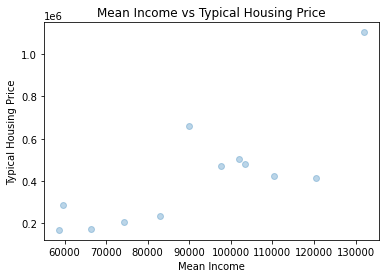

In [23]:
plt.scatter(msazhvi["Mean Income"], msazhvi["2018 ZHVI"], alpha=0.3)
plt.xlabel("Mean Income")
plt.ylabel("Typical Housing Price")
plt.title("Mean Income vs Typical Housing Price")

---
## Questions for Reviewers

- Is having crime and weather data too much to analyze considering all the other data we gathered